In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#from minisom import MiniSom
from tabulate import tabulate
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree, cophenet
from scipy.stats import skew, kurtosis, normaltest, shapiro, probplot, boxcox 

In [2]:
data = pd.read_csv('Wholesale customers data.csv')
df = data.copy()
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


In [5]:
corr = df.corr()
corr

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


In [6]:
df.drop(['Region', 'Channel'], axis=1, inplace=True)

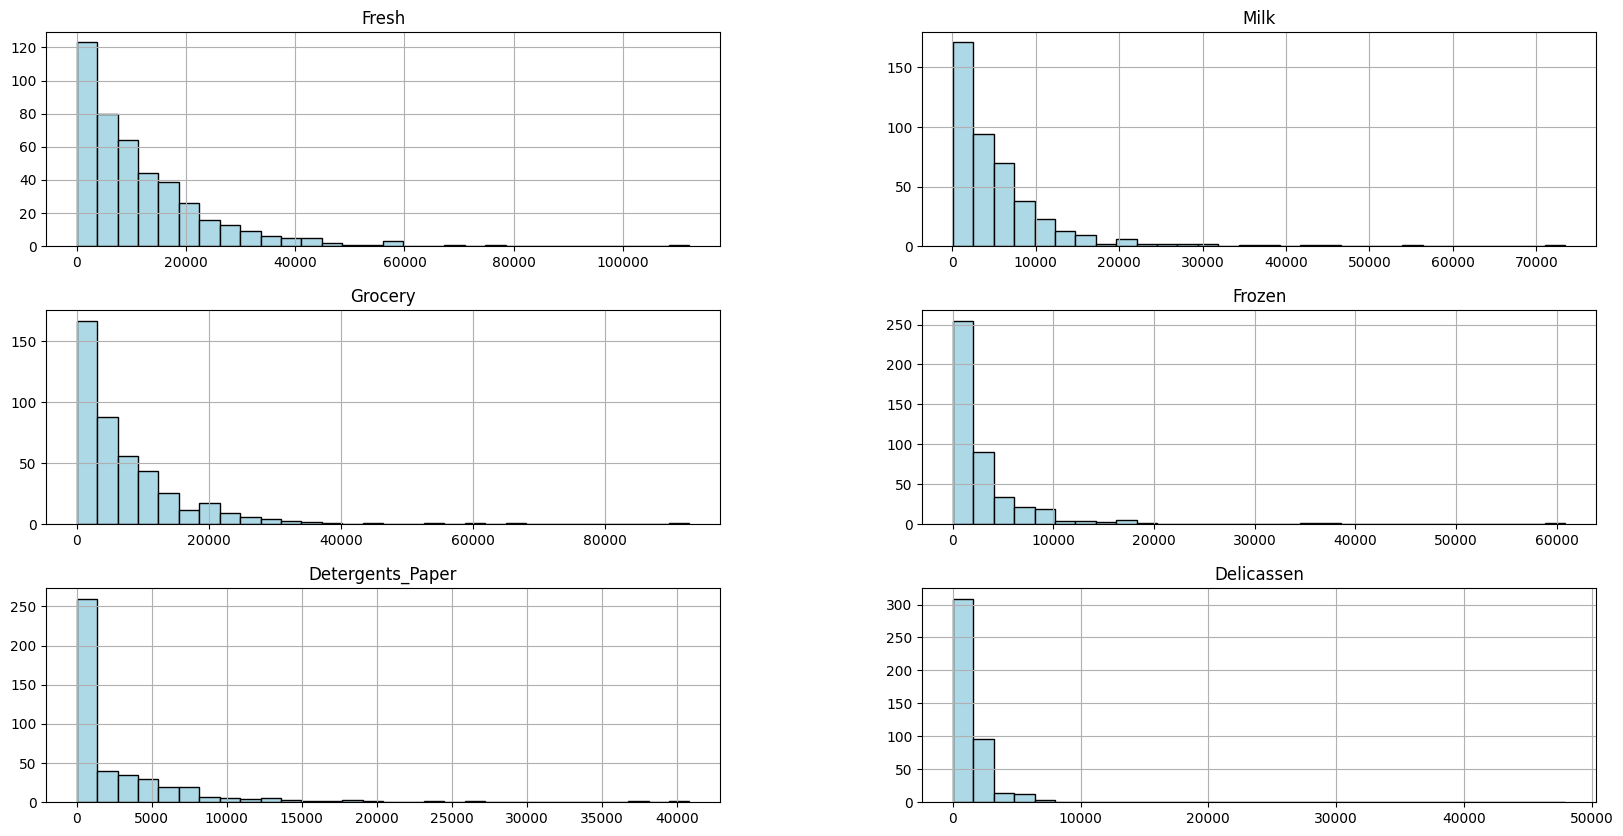

In [7]:
df.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

In [8]:
skewness = df.skew()
kurtosisness = df.kurtosis()

headers = ['Variable', 'Shapiro Test', 'Skewness Coefficient', 'Skewness', 'Kurtosis Coefficient', 'Kurtosis']

table_data = []
for col in df.columns:
    stat, p = normaltest(df[col])
    normal_dist = 'Yes' if p >= 0.05 else 'No'
    skewness_val = f'{skewness[col]:.4f}'
    skewness_desc = 'Highly skewed' if skewness[col] < -1 or skewness[col] > 1 else 'Symmetric or mildly skewed'
    kurtosis_val = f'{kurtosisness[col]:.4f}'
    kurtosis_desc = 'Very flat or sharp' if kurtosisness[col] < -2 or kurtosisness[col] > 2 else 'Normal or mildly flat'

    stat_sh, p_sh = shapiro(df[col])
    shapiro_test = 'Yes' if p_sh >= 0.05 else 'No'
    
    table_data.append([col, shapiro_test, skewness_val, skewness_desc, kurtosis_val, kurtosis_desc])

table = tabulate(table_data, headers, tablefmt='pretty')
print(table)

+------------------+--------------+----------------------+---------------+----------------------+--------------------+
|     Variable     | Shapiro Test | Skewness Coefficient |   Skewness    | Kurtosis Coefficient |      Kurtosis      |
+------------------+--------------+----------------------+---------------+----------------------+--------------------+
|      Fresh       |      No      |        2.5613        | Highly skewed |       11.5364        | Very flat or sharp |
|       Milk       |      No      |        4.0538        | Highly skewed |       24.6694        | Very flat or sharp |
|     Grocery      |      No      |        3.5874        | Highly skewed |       20.9147        | Very flat or sharp |
|      Frozen      |      No      |        5.9080        | Highly skewed |       54.6893        | Very flat or sharp |
| Detergents_Paper |      No      |        3.6319        | Highly skewed |       19.0095        | Very flat or sharp |
|    Delicassen    |      No      |       11.151

In [9]:
normality=pd.DataFrame(index=['p-value', 'test-statistic'])
for i in df.columns:
    normality[i]=shapiro(df[i])
    
normality.T

,p-value,test-statistic
Fresh,0.781436,7.918344e-24
Milk,0.628334,9.762267e-30
Grocery,0.676230,3.906112e-28
Frozen,0.528297,1.291356e-32
Detergents_Paper,0.605482,1.914582e-30
Delicassen,0.361068,1.753416e-36


In [10]:
df = np.log(df)

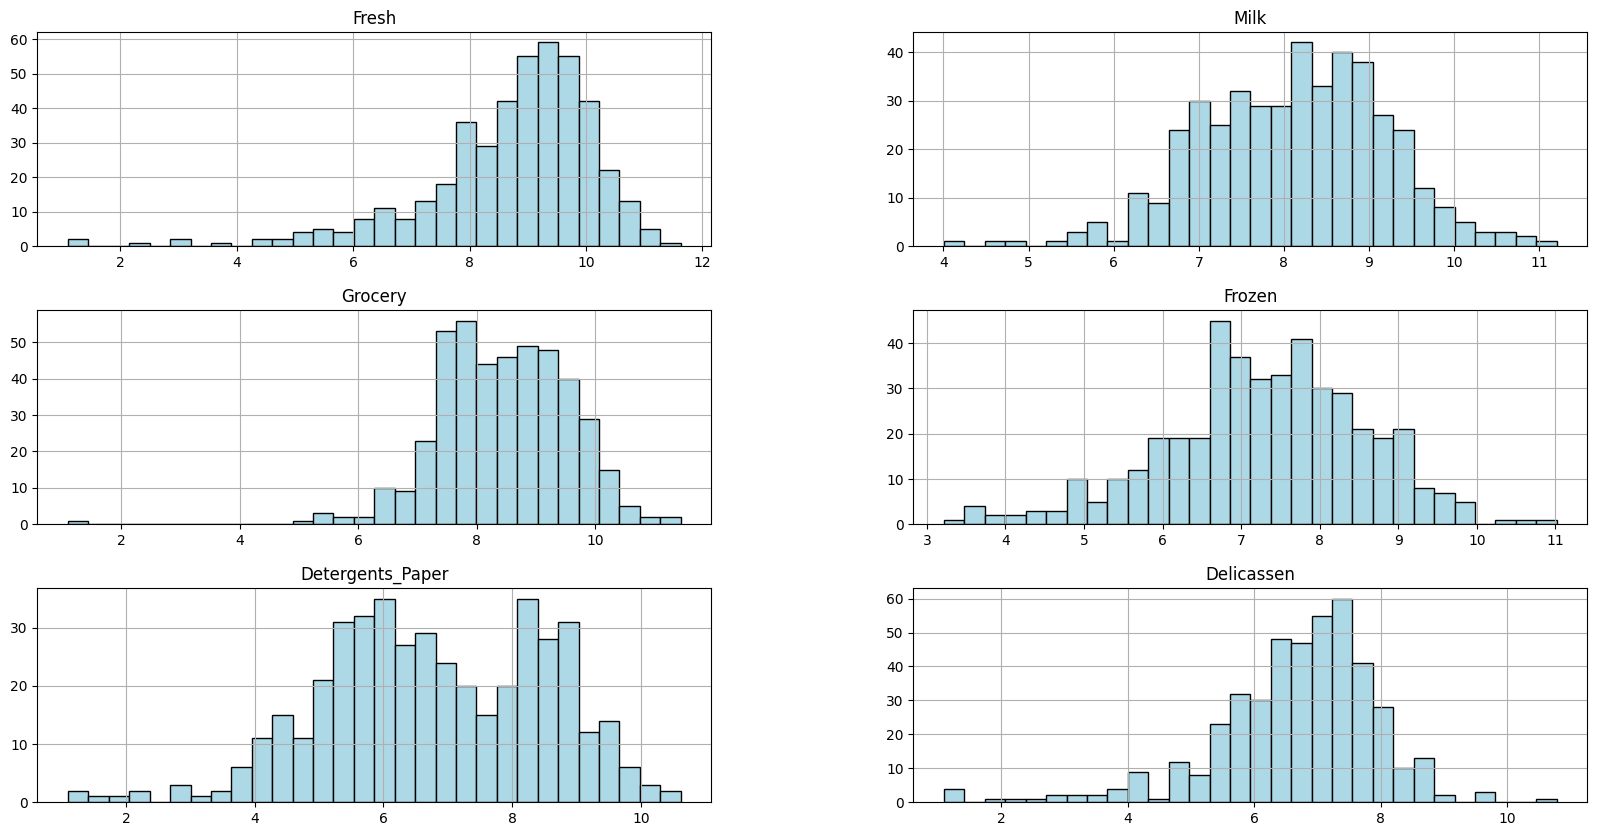

In [11]:
df.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

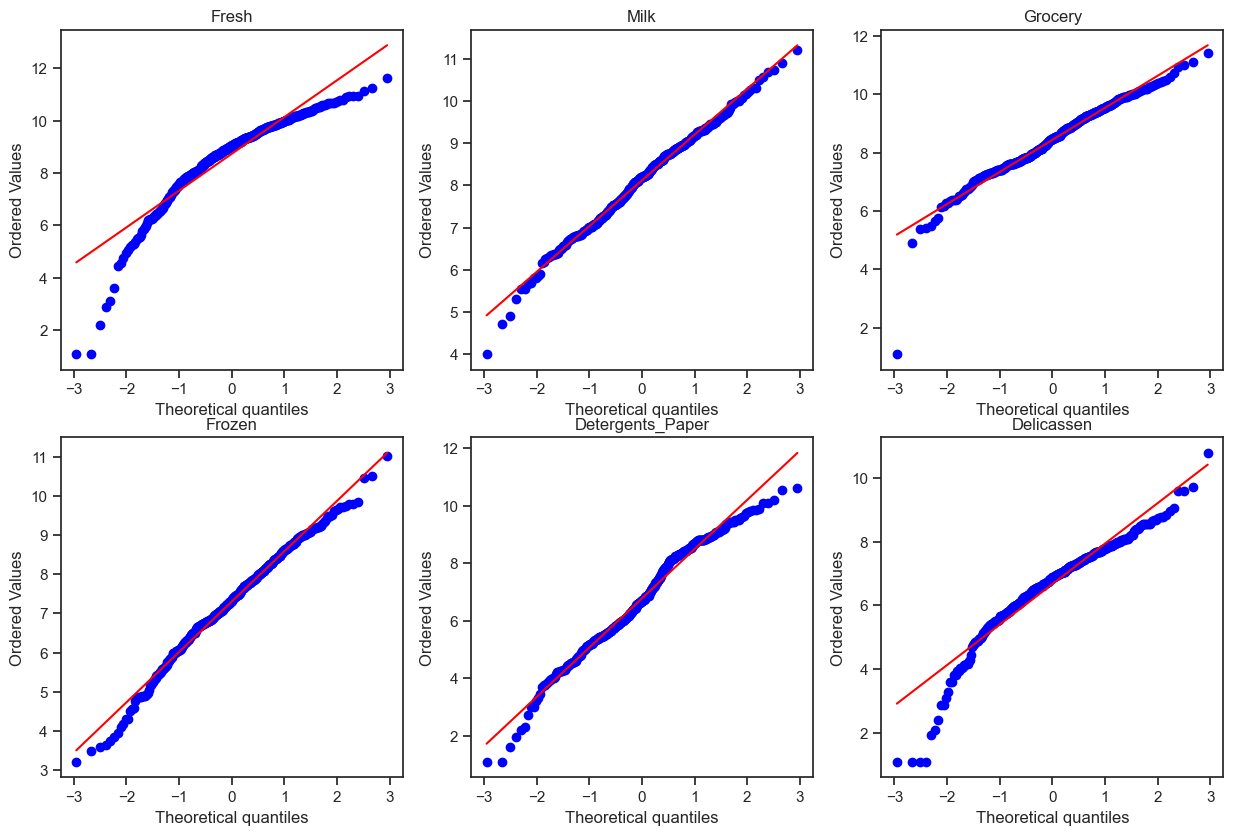

In [17]:
plt.figure(figsize=(15,15))
for i,var in enumerate(df.columns):
    plt.subplot(3,3,i+1)
    probplot(df[var], plot=plt)
    plt.title(f'{var}')
plt.show()  

<Axes: >

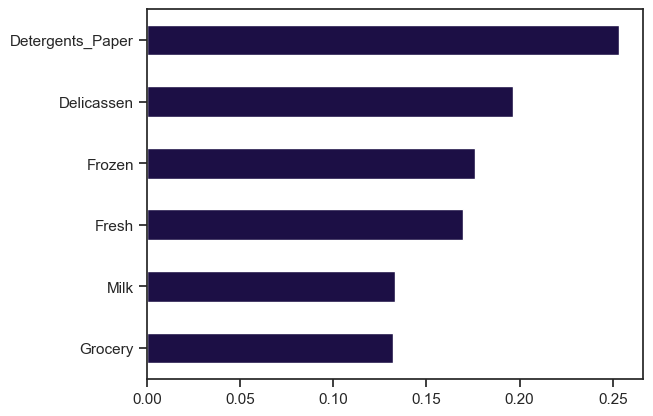

In [18]:
variability_coefficient = df.std() / df.mean()
sorted_vc = variability_coefficient.sort_values()
sorted_vc.plot.barh(x='Variables', y='Variability Coefficient')

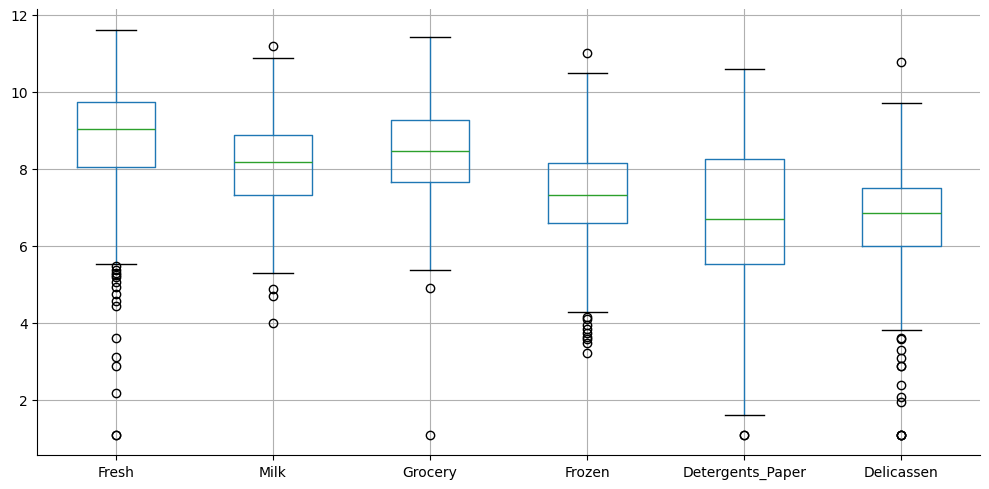

In [14]:
plt.figure(figsize=(10, 5))
df.boxplot()
sns.despine()
plt.tight_layout()
plt.show()

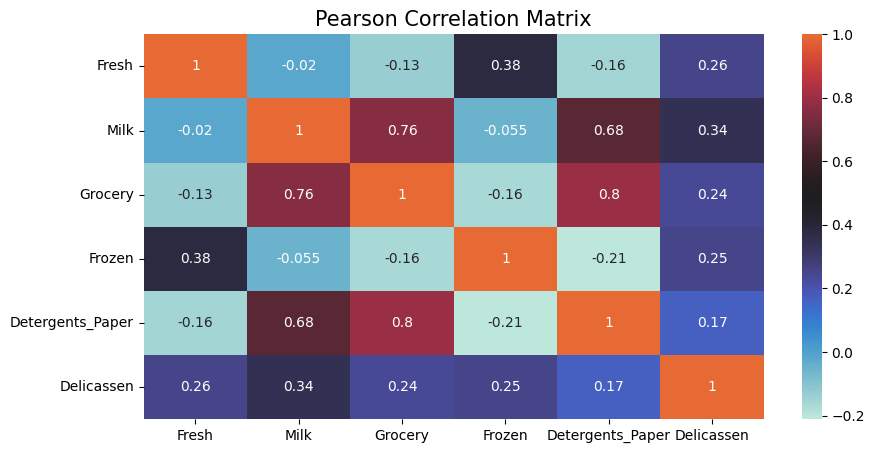

In [15]:
corr=df.corr()
plt.figure(figsize=(10,5))
plt.title('Pearson Correlation Matrix',fontsize=15)
sns.heatmap(corr, center=0.5,annot=True)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

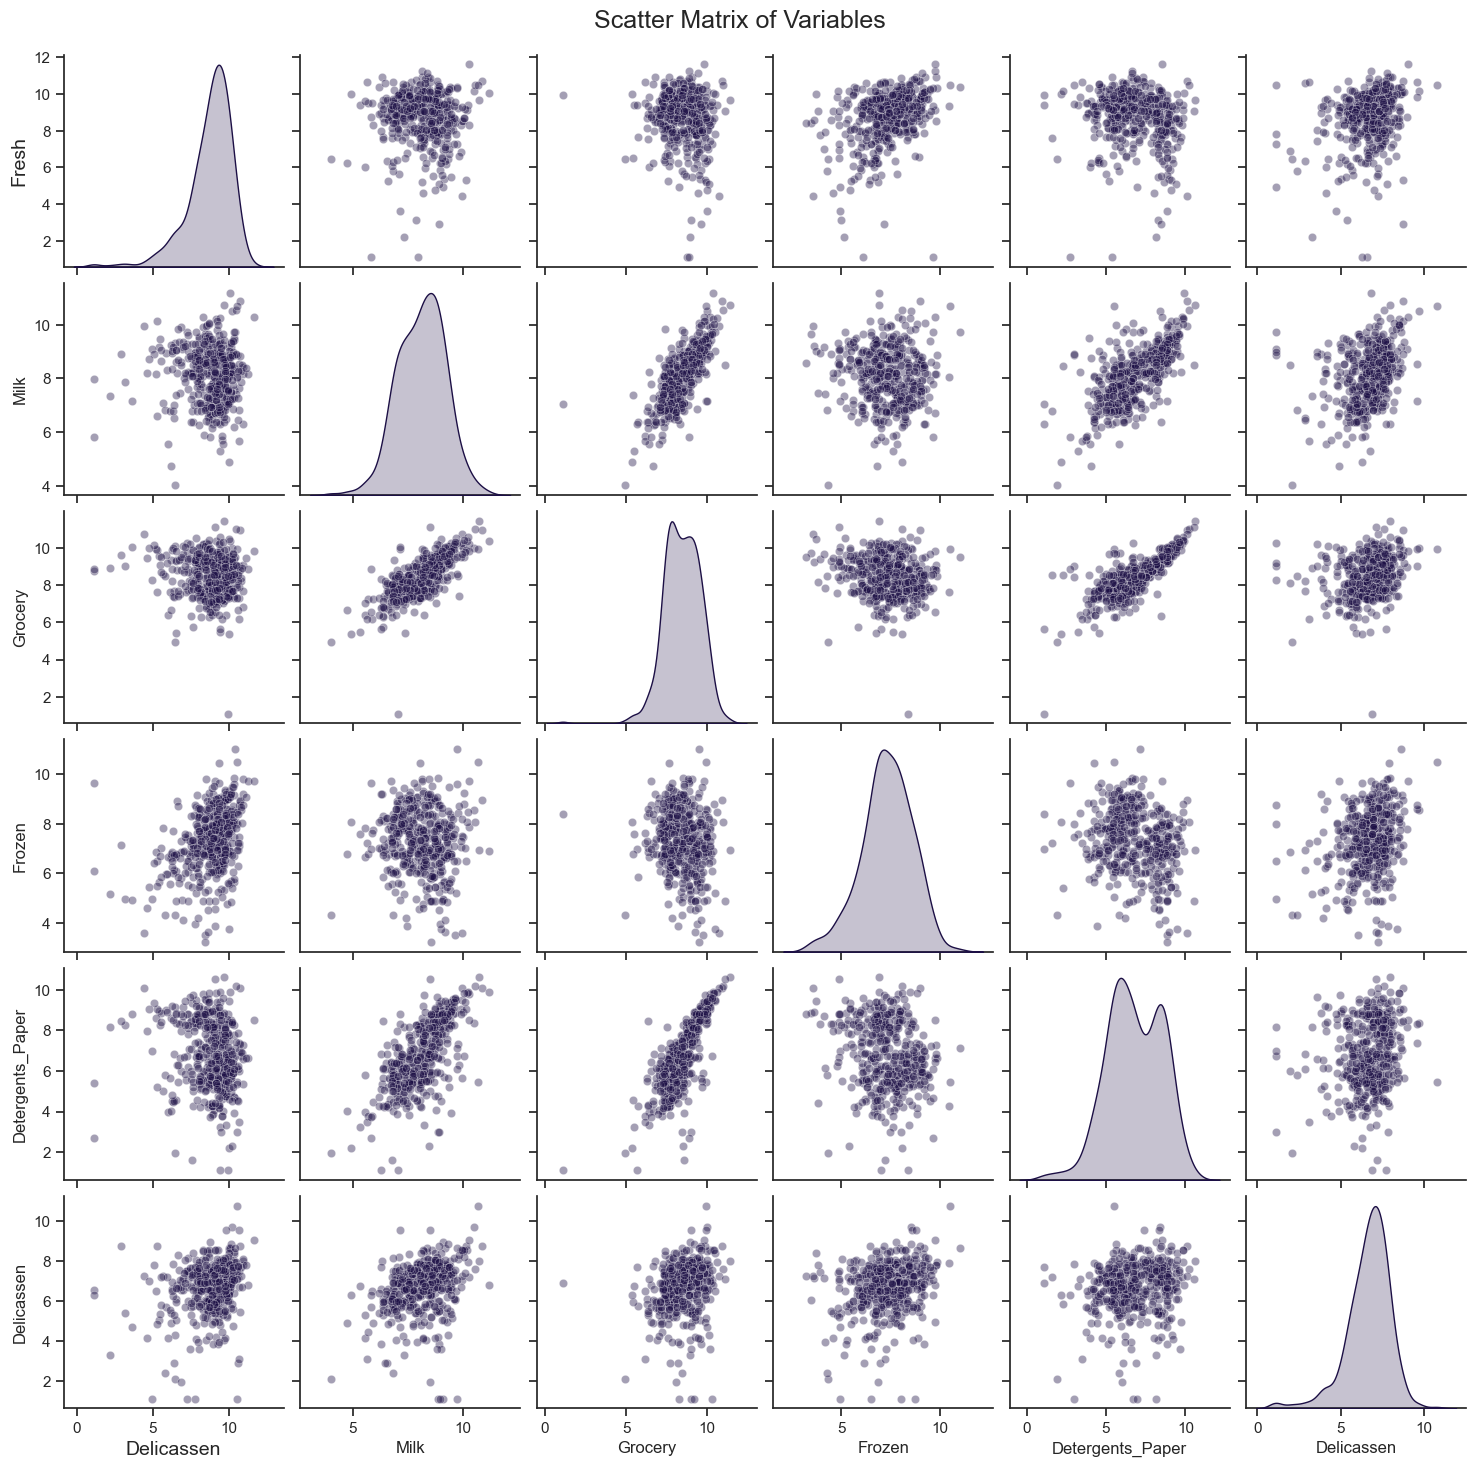

In [16]:
custom_palette = sns.color_palette(['#1c0f45'])
sns.set(style='ticks', palette=custom_palette) 
scatter_matrix = sns.pairplot(df, diag_kind='kde', markers='o', plot_kws={'alpha': 0.4})
plt.subplots_adjust(top=0.95)  
scatter_matrix.fig.suptitle('Scatter Matrix of Variables', fontsize=18)  
scatter_matrix.axes[0, 0].set_ylabel(df.columns[0], fontsize=14)  
scatter_matrix.axes[-1, 0].set_xlabel(df.columns[-1], fontsize=14)  
plt.show()